# Brain Drain Analysis and Country Recommendation System

This notebook explores international migration patterns of highly educated individuals (tertiary-level education), with a focus on understanding their movements across OECD countries. Using real-world datasets (labor force surveys, well-being indicators, political freedom scores), the project integrates:

- **Data cleaning and preparation** of migration and national statistics.
- **Visualization of migration flows** by country of origin and destination.
- **Interactive tools** for comparing countries based on selected quality-of-life indicators.
- **Clustering analysis** to group countries with similar profiles.
- **A personalized country recommendation engine**, where users specify what they seek (or want to leave behind) and receive the best countries to move to.

The goal is to empower users with an analytical yet intuitive experience to understand and reflect on the factors behind migration decisions.

---

⚠️ **Execution Warning**

Some parts of this notebook involve interactive widgets (dropdowns, checkboxes, buttons). To ensure everything works smoothly and you can make proper selections:

> **We recommend running the notebook one cell at a time (manually), not using "Run all"**.

This gives you full control over the interaction flow and prevents errors related to uninitialized inputs or widgets not yet used.

## Create environment

This code block installs the necessary libraries for building interactive and visual applications in Python. It includes:

- `ipywidgets`: For creating interactive widgets in Jupyter notebooks and Colab.
- `streamlit`: A popular framework for building web apps with Python.
- `networkx`, `matplotlib`: For creating and visualizing graphs.
- `graphviz`, `libgraphviz-dev`, and `pygraphviz`: For advanced graph visualization and layout features.

These installations set up the environment to support graph-based visualizations and interactive user interfaces.


In [1]:
!pip install ipywidgets
!pip install streamlit
!pip install ipywidgets
!pip install ipywidgets networkx matplotlib
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libg

##1 – Mount Google Drive and Prepare Dataset Folder

This code block performs the initial setup for data analysis in Google Colab:

- It imports all the necessary Python libraries for data processing, visualization, clustering, dimensionality reduction, graph analysis, and interactive widgets.
- It mounts the user's Google Drive to access datasets stored remotely.
- It defines the path to the dataset folder in Drive and creates a local directory in Colab.
- Finally, it copies all dataset files from Google Drive to the local Colab directory for easier access and manipulation during the analysis.



In [2]:
# Import necessary libraries
from google.colab import drive
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import FuncFormatter
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import matplotlib.ticker as mtick
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib import cm
from networkx.drawing.nx_agraph import graphviz_layout
from IPython.display import HTML
from ipywidgets import Dropdown
import warnings


# Mount Google Drive to access datasets stored in the user's drive
drive.mount('/content/drive')

# Define the path to the dataset folder within Google Drive
folder_path = '/content/drive/MyDrive/Data_Science_Lab/Datasets'

# Create a local directory to store the copied datasets for analysis
download_dir = '/content/dataset_downloaded'
os.makedirs(download_dir, exist_ok=True)

# List all files in the specified folder and copy them locally
file_list = os.listdir(folder_path)
print("Files detected in the specified Google Drive folder:")
for f in file_list:
    full_path = os.path.join(folder_path, f)
    if os.path.isfile(full_path):
        print(f"Copying file: {f}")
        shutil.copy(full_path, os.path.join(download_dir, f))

print("\nAll files have been successfully copied to the local directory: /content/dataset_downloaded")


Mounted at /content/drive
Files detected in the specified Google Drive folder:
Copying file: All_data_FIW_2013_2024.xlsx
Copying file: OECD_regioni.xlsx
Copying file: t3_TOP100.xlsx
Copying file: t4_TOP100.xlsx
Copying file: t5_TOP100.xlsx
Copying file: t6_TOP100.xlsx
Copying file: OECD_nazioni.xlsx
Copying file: t1_TOP100.xlsx
Copying file: df_spostamenti.csv
Copying file: df_nazioni.csv
Copying file: dataset_final.csv

All files have been successfully copied to the local directory: /content/dataset_downloaded


## 2 – Load, Clean, and Aggregate Migration Data

This code block loads multiple Excel datasets containing migration data and performs the following preprocessing steps:

- Loads five Excel files into individual DataFrames.
- Ensures all datasets have the same structure by aligning columns.
- Merges them into a single DataFrame.
- Removes irrelevant or redundant columns.
- Filters the data to include only individuals with known country of birth and tertiary education.
- Drops all rows with missing values.
- Aggregates the total number of people by country of birth, country of destination, education level, and sex.
- Renames key columns for clarity.



In [3]:
# --- Define the paths to the Excel files to be loaded ---
file_paths = [
    "dataset_downloaded/t1_TOP100.xlsx",
    "dataset_downloaded/t3_TOP100.xlsx",
    "dataset_downloaded/t4_TOP100.xlsx",
    "dataset_downloaded/t5_TOP100.xlsx",
    "dataset_downloaded/t6_TOP100.xlsx"
]

# --- Load each Excel file into a separate pandas DataFrame ---
dfs = [pd.read_excel(fp) for fp in file_paths]

# --- Collect the union of all column names present in at least one dataset ---
all_columns = set()
for df in dfs:
    all_columns.update(df.columns)

# --- Ensure all DataFrames share the same set of columns (add missing columns as NaN) ---
all_columns = sorted(list(all_columns))  # Sorted for consistent column order
dfs_aligned = [df.reindex(columns=all_columns) for df in dfs]

# --- Merge all aligned DataFrames into a single consolidated dataset ---
df = pd.concat(dfs_aligned, ignore_index=True)
print(f"Shape after concatenation: {df.shape}")

# --- Drop columns deemed non-relevant or redundant for the analysis ---
columns_to_remove = [
    'age_lfs', 'oecd', 'lfs', 'dos_cen', 'fborn',
    'oecdb', 'ind_1d', 'ind_2d', 'ind_oth'
]
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

# --- Apply data filtering to exclude irrelevant or invalid entries ---
# Exclude records where the country of birth is coded as '99' (unknown or undefined)
df = df[df["coub"] != '99']

# Retain only individuals with tertiary education (ISCED levels 5 to 8)
df = df[df["edu_lfs"] == "ISCED 5/6/7/8"]

# --- Remove records containing missing values ---
rows_with_nulls = df.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {rows_with_nulls}")

initial_shape = df.shape
df = df.dropna(axis=0)
print(f"Original shape: {initial_shape}")
print(f"Shape after removing missing values: {df.shape}")

# --- Aggregate the number of people by unique combinations of key attributes ---
df_spostamenti = df.groupby(
    ["coub", "country", "edu_lfs", "sex"],
    as_index=False
)["number"].sum()

# ---  Rename columns for improved readability and clarity ---
df_spostamenti = df_spostamenti.rename(columns={
    'coub': 'country_of_birth',
    'country': 'country_of_destination',
    'edu_lfs': 'education_level'
})

# --- Final output: aggregated migration flow dataset ---
df_spostamenti


Shape after concatenation: (603026, 14)
Rows with at least one missing value: 0
Original shape: (206983, 5)
Shape after removing missing values: (206983, 5)


,country_of_birth,country_of_destination,education_level,sex,number
0,AFG,AUS,ISCED 5/6/7/8,Female,22351.0
1,AFG,AUS,ISCED 5/6/7/8,Male,24308.0
2,AFG,BGR,ISCED 5/6/7/8,Female,68.0
3,AFG,BGR,ISCED 5/6/7/8,Male,420.0
4,AFG,CAN,ISCED 5/6/7/8,Female,43995.0
...,...,...,...,...,...
4685,ZAF,SWE,ISCED 5/6/7/8,Male,3610.0
4686,ZAF,TUR,ISCED 5/6/7/8,Female,158.0
4687,ZAF,TUR,ISCED 5/6/7/8,Male,144.0
4688,ZAF,USA,ISCED 5/6/7/8,Female,165245.0


## 3 – Load, Clean, and Merge National Indicators with Freedom House Data

This code block loads national and regional OECD datasets along with political freedom data from Freedom House.

It performs the following steps:

- Loads the datasets and selects only Freedom House editions from 2020 and 2021.
- Cleans column names and replaces placeholder strings for missing values.
- Converts numerical data to the correct format.
- Fills missing or zero national values with country-level averages from regional data.
- Computes the average of Political Rights (PR) and Civil Liberties (CL) scores over 2020–2021.
- Merges these averaged scores with the national dataset.
- Manually imputes values for countries with mismatched naming conventions.



In [4]:
# --- Load data sources ---
df_nazioni = pd.read_excel("dataset_downloaded/OECD_nazioni.xlsx")
df_regioni = pd.read_excel("dataset_downloaded/OECD_regioni.xlsx")
df_freedom = pd.read_excel("dataset_downloaded/All_data_FIW_2013_2024.xlsx")
df_freedom = df_freedom[df_freedom["Edition"].isin([2020, 2021])]

# --- Clean column names by removing leading/trailing whitespace ---
df_nazioni.columns = df_nazioni.columns.str.strip()
df_regioni.columns = df_regioni.columns.str.strip()
df_freedom.columns = df_freedom.columns.str.strip()

# --- Replace placeholder strings and convert numeric fields to float ---
df_nazioni.replace("..", np.nan, inplace=True)
df_regioni.replace("..", np.nan, inplace=True)

# Convert columns to numeric (with comma as decimal separator)
for col in df_nazioni.columns[2:]:
    df_nazioni[col] = df_nazioni[col].astype(str).str.replace(",", ".").astype(float)

for col in df_regioni.columns:
    if col not in ['Country', 'Acronym']:
        try:
            df_regioni[col] = df_regioni[col].astype(str).str.replace(",", ".").astype(float)
        except:
            continue  # Skip columns that cannot be converted

# --- Compute mean values at the regional (country) level ---
regional_means = df_regioni.groupby("Country").mean(numeric_only=True).reset_index()

# --- Impute missing or zero values in national indicators using regional averages ---
for col in df_nazioni.columns[2:]:
    for i, row in df_nazioni.iterrows():
        val = row[col]
        if pd.isna(val) or val == 0.0:
            country = row["Country"]
            mean_val = regional_means.loc[regional_means["Country"] == country, col]
            if not mean_val.empty and not pd.isna(mean_val.values[0]):
                df_nazioni.at[i, col] = mean_val.values[0]

df_freedom = df_freedom.rename(columns={"Country/Territory": "Country"})
freedom_avg = (
    df_freedom.groupby("Country")[["PR rating", "CL rating"]]
    .mean()
    .reset_index()
)
freedom_avg["PR rating"] = freedom_avg["PR rating"].round(1)
freedom_avg["CL rating"] = freedom_avg["CL rating"].round(1)

# --- Merge Freedom House political freedom scores with national data ---
df_nazioni["Country"] = df_nazioni["Country"].astype(str)
freedom_avg["Country"] = freedom_avg["Country"].astype(str)

df_nazioni = pd.merge(df_nazioni, freedom_avg, on="Country", how="left")

# --- Manually impute missing PR/CL scores for known countries with inconsistent naming conventions ---
df_nazioni.loc[df_nazioni["Country"] == "Türkiye", ["PR rating", "CL rating"]] = [5, 6]
df_nazioni.loc[df_nazioni["Country"] == "Slovak Republic", ["PR rating", "CL rating"]] = [1, 1.5]
df_nazioni.loc[df_nazioni["Country"] == "Korea", ["PR rating", "CL rating"]] = [2, 2]

# --- Final output: enhanced national dataset with averaged freedom indicators ---
print("National data completed and merged with political freedom indicators (2020–2021).")
display(df_nazioni)


National data completed and merged with political freedom indicators (2020–2021).


/tmp/ipython-input-770626265.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_nazioni.replace("..", np.nan, inplace=True)
/tmp/ipython-input-770626265.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_regioni.replace("..", np.nan, inplace=True)


,Country,Acronym,Education,Jobs,Income,Safety,Health,Environment,Civic engagement,Accessiblity to services,Housing,Community,Life satisfaction,PR rating,CL rating
0,Australia,AUS,8.222222,8.293667,6.040590,9.761905,8.988312,8.281250,9.721040,5.010689,9.352518,8.703704,8.461538,1.0,1.0
1,Austria,AUT,8.425926,7.481343,5.089838,9.920635,6.890476,6.875000,6.831017,5.501888,5.755396,7.160494,8.461538,1.0,1.0
2,Belgium,BEL,7.611111,6.282019,4.624354,9.642857,6.659524,6.718750,10.000000,6.937471,7.913669,6.851852,7.307692,1.0,1.0
3,Canada,CAN,9.629630,7.206031,5.138249,9.285714,7.734199,9.166667,7.144778,8.316103,8.576741,8.086420,8.076923,1.0,1.0
4,Chile,CHL,5.851852,4.071702,0.984034,8.809524,7.917965,2.618050,0.354101,2.915937,2.158273,5.185185,4.615385,1.0,1.5
5,Colombia,COL,3.407407,0.929054,0.906754,3.219572,4.302814,5.208333,3.424473,1.211013,0.739894,3.086420,3.461538,3.0,3.0
6,Costa Rica,CRI,0.475690,0.760135,1.282177,5.595238,10.000000,5.156250,4.612281,4.163389,0.143885,5.123457,6.923077,1.0,1.0
7,Czech Republic,CZE,10.000000,9.087838,3.283759,9.642857,3.098701,5.156250,3.514119,5.207948,3.597122,8.209877,7.307692,1.0,1.0
8,Denmark,DNK,7.722222,8.415440,3.902155,9.801587,6.966017,7.864583,8.646347,8.987298,6.474820,9.691358,10.000000,1.0,1.0
9,Estonia,EST,9.092593,7.676987,2.883908,9.325397,4.482251,9.322917,4.164052,5.713048,5.035971,8.271605,4.615385,1.0,1.0


## 4 – Merge Origin & Destination Data, Normalize and Compute Differences

This code block prepares the final dataset for migration analysis by combining national indicators for both origin and destination countries:

- It creates two versions of the national dataset with renamed columns: one for origin countries and one for destination countries.
- These datasets are merged with the migration flow data to enrich it with socio-economic and political indicators.
- Quality-of-life indicators (originally on a 0–10 scale) are normalized to a 0–1 scale.
- Political freedom indicators (originally on a 1–7 scale, where lower is better) are inverted and normalized so that higher values reflect more freedom.
- For each indicator, the difference between destination and origin values is computed to measure the relative gain or loss.
- Intra-country flows and rows with missing data are removed.
- Finally, the prepared dataset is saved to disk for further analysis.



In [5]:
# --- Prepare national indicators for both origin and destination countries ---

# Create a copy of national indicators for origin countries, renaming columns accordingly
df_origin = df_nazioni.copy()
df_origin.columns = ['Country_origin', 'Acronym_origin'] + [f'origin_{col}' for col in df_nazioni.columns[2:]]

# Create a copy of national indicators for destination countries
df_dest = df_nazioni.copy()
df_dest.columns = ['Country_dest', 'Acronym_dest'] + [f'dest_{col}' for col in df_nazioni.columns[2:]]

# --- Merge origin country indicators into the migration dataset ---
df_merged = pd.merge(
    df_spostamenti,
    df_origin,
    left_on='country_of_birth',
    right_on='Acronym_origin',
    how='left'
)

# --- Merge destination country indicators into the dataset ---
df_merged = pd.merge(
    df_merged,
    df_dest,
    left_on='country_of_destination',
    right_on='Acronym_dest',
    how='left'
)

# --- Remove unnecessary columns after merging ---
df_merged.drop(columns=['Acronym_origin', 'Acronym_dest'], inplace=True)

# --- Remove incomplete observations (rows with missing values) ---
df_final = df_merged.dropna()

# --- Remove intra-country flows (where origin and destination are the same) ---
df_final = df_final[df_final["country_of_birth"] != df_final["country_of_destination"]]

# --- Normalize selected indicators (in-place) ---

# Normalize quality-of-life indicators (originally on a 0–10 scale; higher is better)
positive_indicators = [
    'Education', 'Jobs', 'Income', 'Safety', 'Health', 'Environment',
    'Civic engagement', 'Accessiblity to services', 'Housing',
    'Community', 'Life satisfaction'
]
for indicator in positive_indicators:
    df_final[f'origin_{indicator}'] = df_final[f'origin_{indicator}'] / 10.0
    df_final[f'dest_{indicator}'] = df_final[f'dest_{indicator}'] / 10.0

# Normalize and invert political freedom indicators (originally on a 1–7 scale; lower is better)
# Inversion ensures higher values represent more freedom
freedom_indicators = ['PR rating', 'CL rating']
for indicator in freedom_indicators:
    df_final[f'origin_{indicator}'] = (8 - df_final[f'origin_{indicator}']) / 7.0
    df_final[f'dest_{indicator}'] = (8 - df_final[f'dest_{indicator}']) / 7.0

# --- Compute difference between destination and origin for each indicator ---
# Positive differences indicate improvement in conditions from origin to destination
all_indicators = positive_indicators + freedom_indicators
for indicator in all_indicators:
    col_orig = f'origin_{indicator}'
    col_dest = f'dest_{indicator}'
    col_diff = f'diff_{indicator}'
    df_final[col_diff] = df_final[col_dest] - df_final[col_orig]

df_final = df_final.rename(columns={
    "dest_Accessiblity to services": "dest_Accessibility to services",
    "origin_Accessiblity to services": "origin_Accessibility to services",
    "diff_Accessiblity to services": "diff_Accessibility to services"
})

# --- Print final dataset dimensions ---
print(f"Final dataset prepared: {df_final.shape[0]} rows, {df_final.shape[1]} columns")

# --- Save key datasets to disk for later use ---
df_final.to_csv("dataset_final.csv", index=False)
df_spostamenti.to_csv("df_spostamenti.csv", index=False)
df_nazioni.to_csv("df_nazioni.csv", index=False)

df_final


Final dataset prepared: 1166 rows, 46 columns


,country_of_birth,country_of_destination,education_level,sex,number,Country_origin,origin_Education,origin_Jobs,origin_Income,origin_Safety,...,diff_Safety,diff_Health,diff_Environment,diff_Civic engagement,diff_Accessibility to services,diff_Housing,diff_Community,diff_Life satisfaction,diff_PR rating,diff_CL rating
201,AUS,CAN,ISCED 5/6/7/8,Female,47470.000000,Australia,0.822222,0.829367,0.604059,0.976190,...,-0.047619,-0.125411,0.088542,-0.257626,0.330541,-0.077578,-0.061728,-0.038462,0.000000,0.000000
202,AUS,CAN,ISCED 5/6/7/8,Male,45530.000000,Australia,0.822222,0.829367,0.604059,0.976190,...,-0.047619,-0.125411,0.088542,-0.257626,0.330541,-0.077578,-0.061728,-0.038462,0.000000,0.000000
203,AUS,CHE,ISCED 5/6/7/8,Female,8459.370064,Australia,0.822222,0.829367,0.604059,0.976190,...,0.015873,-0.029307,-0.046875,-0.915308,0.474776,-0.359712,0.012346,0.115385,0.000000,0.000000
204,AUS,CHE,ISCED 5/6/7/8,Male,9240.039009,Australia,0.822222,0.829367,0.604059,0.976190,...,0.015873,-0.029307,-0.046875,-0.915308,0.474776,-0.359712,0.012346,0.115385,0.000000,0.000000
205,AUS,COL,ISCED 5/6/7/8,Female,341.000000,Australia,0.822222,0.829367,0.604059,0.976190,...,-0.654233,-0.468550,-0.307292,-0.629657,-0.379968,-0.861262,-0.561728,-0.500000,-0.285714,-0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,USA,SVN,ISCED 5/6/7/8,Male,633.000000,United States,0.933333,0.734419,1.000000,0.753968,...,0.246032,0.256840,-0.343750,-0.317346,-0.272776,-0.568345,0.148148,-0.192308,0.142857,0.071429
4182,USA,SWE,ISCED 5/6/7/8,Female,25500.000000,United States,0.933333,0.734419,1.000000,0.753968,...,0.214286,0.536450,0.109375,0.454953,-0.096901,-0.424460,0.049383,0.153846,0.142857,0.071429
4183,USA,SWE,ISCED 5/6/7/8,Male,26115.000000,United States,0.933333,0.734419,1.000000,0.753968,...,0.214286,0.536450,0.109375,0.454953,-0.096901,-0.424460,0.049383,0.153846,0.142857,0.071429
4184,USA,TUR,ISCED 5/6/7/8,Female,2714.000000,United States,0.933333,0.734419,1.000000,0.753968,...,-0.031746,0.109913,-0.770833,0.413043,-0.485014,-0.770825,-0.679012,-0.715448,-0.428571,-0.642857


## 5 - Basic Info and Descriptive Visualizations

This code block provides an initial overview and basic visual exploration of the final migration dataset:

- It prints structural information (`.info()`) and descriptive statistics (`.describe()`).
- It counts how many rows contain missing values.
- It calculates the total number of recorded migrations and aggregates this by sex.
- It generates visualizations:
  - A bar chart showing the number of migrants by sex.
  - A chart showing the number of people migrating *from* each country of birth.
  - A chart showing the number of people migrating *to* each country of destination.

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1166 entries, 201 to 4185
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_of_birth                  1166 non-null   object 
 1   country_of_destination            1166 non-null   object 
 2   education_level                   1166 non-null   object 
 3   sex                               1166 non-null   object 
 4   number                            1166 non-null   float64
 5   Country_origin                    1166 non-null   object 
 6   origin_Education                  1166 non-null   float64
 7   origin_Jobs                       1166 non-null   float64
 8   origin_Income                     1166 non-null   float64
 9   origin_Safety                     1166 non-null   float64
 10  origin_Health                     1166 non-null   float64
 11  origin_Environment                1166 non-null   float64


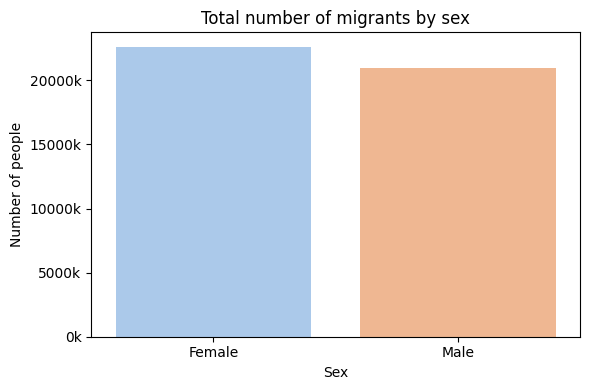

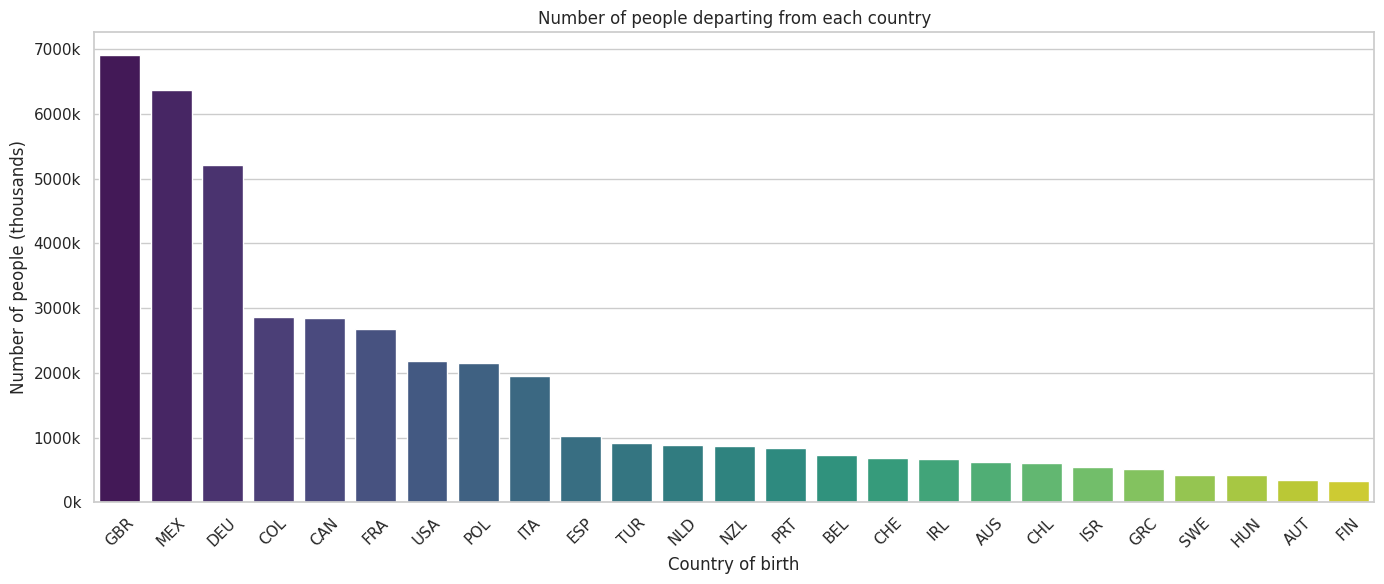

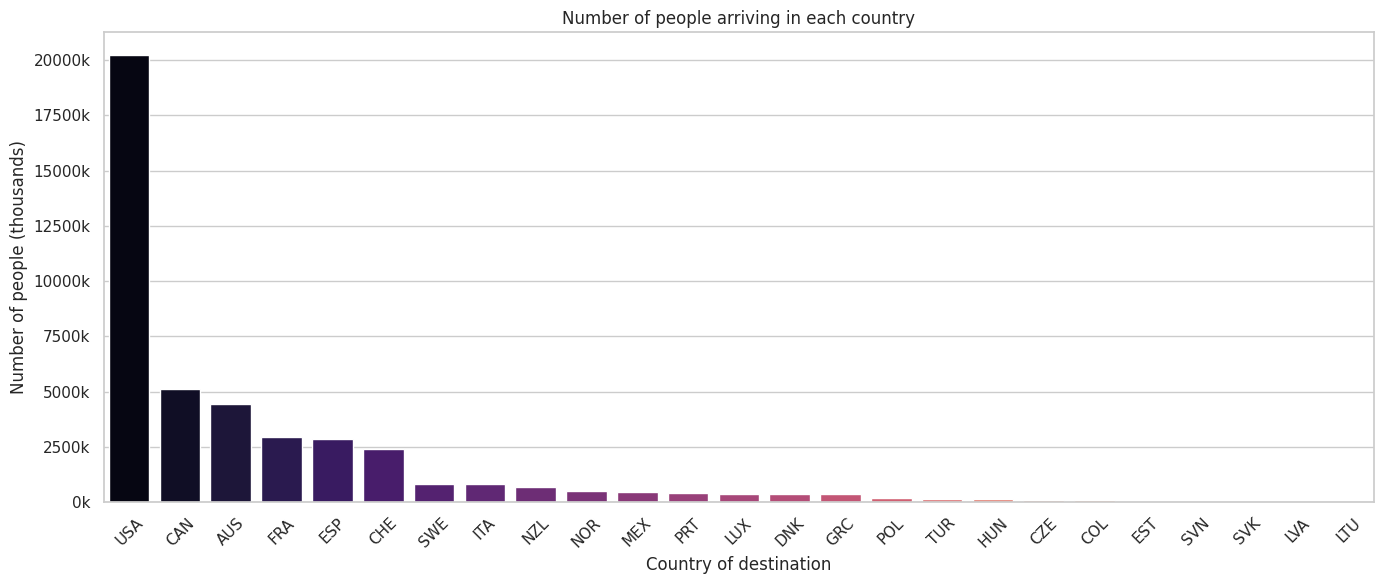

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Basic dataset overview ---
print("Dataset info:")
print(df_final.info())

print("\nDescriptive statistics:")
print(df_final.describe(include='all'))

# --- Count of rows containing at least one missing value ---
n_null_rows = df_final.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {n_null_rows}")

# --- Total number of recorded migrations ---
total_sum = df_final["number"].sum()
print(f"Total number of migrations: {total_sum:,.0f}")

# --- Total number of migrants by sex ---
df_sex_totals = df_final.groupby("sex")["number"].sum().reset_index()
df_sex_totals = df_sex_totals.sort_values(by="number", ascending=False)

# --- Bar plot: migrants by sex ---
plt.figure(figsize=(6, 4))
sns.barplot(x="sex", y="number", data=df_sex_totals, palette="pastel")
plt.title("Total number of migrants by sex")
plt.xlabel("Sex")
plt.ylabel("Number of people")

# Format y-axis with thousands as "k"
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

plt.tight_layout()
plt.show()

# Set Seaborn visual style
sns.set(style="whitegrid")

# --- Helper: formatter for thousands ---
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

formatter = FuncFormatter(thousands_formatter)

# --- Chart 1: Number of people migrating *from* each country of birth ---
plt.figure(figsize=(14, 6))
birth_counts = df_final.groupby("country_of_birth")["number"].sum().sort_values(ascending=False)
sns.barplot(x=birth_counts.index, y=birth_counts.values, palette="viridis")
plt.title("Number of people departing from each country")
plt.xlabel("Country of birth")
plt.ylabel("Number of people (thousands)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# --- Chart 2: Number of people migrating *to* each country of destination ---
plt.figure(figsize=(14, 6))
dest_counts = df_final.groupby("country_of_destination")["number"].sum().sort_values(ascending=False)
sns.barplot(x=dest_counts.index, y=dest_counts.values, palette="magma")
plt.title("Number of people arriving in each country")
plt.xlabel("Country of destination")
plt.ylabel("Number of people (thousands)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


## 6 - Country Comparison Tool

This section provides an interactive interface for comparing two destination countries based on selected socio-economic and political indicators.

- Users can choose two countries from dropdown menus.
- They can select one or more indicators using checkboxes.
- Upon clicking the "Compare Countries" button, a side-by-side bar chart is displayed, showing the average normalized values for each selected indicator in the two countries.



In [7]:
# --- Define the list of available indicators for comparison ---
available_indices = [
    "Education", "Jobs", "Income", "Safety", "Health", "Environment",
    "Civic engagement", "Accessibility to services", "Housing",
    "Community", "Life satisfaction", "PR rating", "CL rating"
]

# --- Create a mapping with ALL countries (origin + destination) ---
all_countries_df = pd.concat([
    df_final[["country_of_birth", "Country_origin"]].rename(
        columns={"country_of_birth": "code", "Country_origin": "name"}
    ),
    df_final[["country_of_destination", "Country_dest"]].rename(
        columns={"country_of_destination": "code", "Country_dest": "name"}
    )
]).drop_duplicates().sort_values("name")

country_display_map = {
    f"{code} - {name}": code
    for code, name in all_countries_df.values
}

# --- Dropdown widgets ---
country_1_widget = widgets.Dropdown(
    options=sorted(country_display_map.keys()),
    description="Country 1:"
)
country_2_widget = widgets.Dropdown(
    options=sorted(country_display_map.keys()),
    description="Country 2:"
)

# --- Checkbox widgets for selecting indicators ---
checkbox_indices = []
for index in available_indices:
    checkbox = widgets.Checkbox(value=False, description=index)
    checkbox_indices.append((index, checkbox))

# --- Button and output area ---
btn_compare = widgets.Button(description="Compare Countries", button_style="info")
output_comparison = widgets.Output()

# --- Event handler ---
def on_compare_clicked(b):
    with output_comparison:
        clear_output()

        # Convert display name to actual country code
        country1 = country_display_map[country_1_widget.value]
        country2 = country_display_map[country_2_widget.value]

        # Selected indicators
        selected_indices = [index for index, cb in checkbox_indices if cb.value]
        if not selected_indices:
            print("Please select at least one indicator to compare.")
            return

        def get_country_values(code):
            # Try to retrieve values from destination columns
            row = df_final[df_final["country_of_destination"] == code]
            prefix = "dest_"
            if row.empty:
                # If not available as a destination, use origin columns
                row = df_final[df_final["country_of_birth"] == code]
                prefix = "origin_"
            # Take the first row and extract the selected indicators
            values = row[[f"{prefix}{i}" for i in selected_indices]].iloc[0]
            values.index = [i.replace(prefix, "") for i in values.index]
            return values

        means_c1 = get_country_values(country1)
        means_c2 = get_country_values(country2)

        # --- Plot ---
        x = range(len(selected_indices))
        width = 0.35
        plt.figure(figsize=(10, 6))
        plt.bar([i - width/2 for i in x], means_c1.values, width=width, label=country_1_widget.value)
        plt.bar([i + width/2 for i in x], means_c2.values, width=width, label=country_2_widget.value)
        plt.xticks(x, selected_indices, rotation=45, ha='right')
        plt.ylabel("Normalized Value")
        plt.title("Comparison of Selected Indicators Between Countries")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

btn_compare.on_click(on_compare_clicked)

# --- Display UI ---
display(widgets.HTML("<h3>Select the two countries to compare</h3>"))
display(widgets.HBox([country_1_widget, country_2_widget]))
display(widgets.HTML("<h3>Select the indicators to include in the comparison</h3>"))
for _, cb in checkbox_indices:
    display(cb)
display(btn_compare, output_comparison)


HTML(value='<h3>Select the two countries to compare</h3>')

HTML(value='<h3>Select the indicators to include in the comparison</h3>')

Checkbox(value=False, description='Education')

Checkbox(value=False, description='Jobs')

Checkbox(value=False, description='Income')

Checkbox(value=False, description='Safety')

Checkbox(value=False, description='Health')

Checkbox(value=False, description='Environment')

Checkbox(value=False, description='Civic engagement')

Checkbox(value=False, description='Accessibility to services')

Checkbox(value=False, description='Housing')

Checkbox(value=False, description='Community')

Checkbox(value=False, description='Life satisfaction')

Checkbox(value=False, description='PR rating')

Checkbox(value=False, description='CL rating')

Button(button_style='info', description='Compare Countries', style=ButtonStyle())

Output()

## 7 - Country Clustering Interface

This interactive tool allows you to explore **similarities between countries** by grouping them into clusters based on selected wellbeing and political indicators.

- Select at least **two indicators** using the checkboxes.
- Click **"Create Clusters"** to apply k-means clustering:
  - The system automatically selects the optimal number of clusters using silhouette scores.
  - If more than two indicators are selected, the data is reduced to two dimensions using PCA.
  - If exactly two indicators are selected, they are used directly as axes.

The result is a 2D scatter plot where countries are grouped by similarity, allowing for intuitive comparison between national profiles.


In [8]:
warnings.filterwarnings("ignore", category=FutureWarning)

# === Define available indicators for clustering ===
indices = [
    "Education", "Jobs", "Income", "Safety", "Health", "Environment",
    "Civic engagement", "Accessibility to services", "Housing",
    "Community", "Life satisfaction", "PR rating", "CL rating"
]
checkbox_indices = [widgets.Checkbox(value=False, description=i) for i in indices]
index_box = widgets.VBox(checkbox_indices)

# === Initialize button and output widget ===
cluster_button = widgets.Button(description="Create Clusters", button_style="success")
output = widgets.Output()

# === Callback function: clustering pipeline ===
def on_button_clicked(b):
    clear_output()

    # Retrieve selected indicators
    selected = [cb.description for cb in checkbox_indices if cb.value]
    print(f"Selected indicators: {selected}")

    if len(selected) < 2:
        print("Please select at least two indicators to proceed with clustering.")
        return

    try:
        # --- Create a complete list of countries ---
        all_countries_df = pd.concat([
            df_final[["country_of_birth", "Country_origin"]].rename(
                columns={"country_of_birth": "code", "Country_origin": "name"}
            ),
            df_final[["country_of_destination", "Country_dest"]].rename(
                columns={"country_of_destination": "code", "Country_dest": "name"}
            )
        ]).drop_duplicates().reset_index(drop=True)

        # --- Function to retrieve indicator values for a country ---
        def get_country_row(code):
            row = df_final[df_final["country_of_destination"] == code]
            prefix = "dest_"
            if row.empty:
                row = df_final[df_final["country_of_birth"] == code]
                prefix = "origin_"
            values = row[[f"{prefix}{i}" for i in selected]].iloc[0]
            values.index = selected  # Rename for clarity
            return values

        # --- Build df_mean with all countries ---
        data_rows = []
        for _, r in all_countries_df.iterrows():
            code = r["code"]
            name = r["name"]
            vals = get_country_row(code)
            data_rows.append({"country_code": code, "country_name": name, **vals})

        df_mean = pd.DataFrame(data_rows)

        # Standardize input features
        X = StandardScaler().fit_transform(df_mean[selected])

        # Project features to 2D space (PCA or raw axes)
        if X.shape[1] > 2:
            pca = PCA(n_components=2)
            X_projected = pca.fit_transform(X)
            df_mean["PCA1"] = X_projected[:, 0]
            df_mean["PCA2"] = X_projected[:, 1]
            print("Applied PCA for dimensionality reduction.")
            x_col, y_col = "PCA1", "PCA2"
            x_label, y_label = "Principal Component 1", "Principal Component 2"
        elif X.shape[1] == 2:
            var1_label = selected[0]
            var2_label = selected[1]
            df_mean[var1_label] = X[:, 0]
            df_mean[var2_label] = X[:, 1]
            print("PCA skipped (exactly 2 features).")
            x_col, y_col = var1_label, var2_label
            x_label, y_label = var1_label, var2_label
        else:
            print("Not enough features for 2D visualization.")
            return

        # Determine optimal number of clusters using silhouette scores
        silhouette_scores = []
        cluster_range = range(2, min(10, len(df_mean)))
        for k in cluster_range:
            km = KMeans(n_clusters=k, n_init="auto", random_state=42)
            labels = km.fit_predict(X)
            score = silhouette_score(X, labels)
            silhouette_scores.append((k, score))

        best_k = max(silhouette_scores, key=lambda x: x[1])[0]
        print(f"Optimal number of clusters: {best_k}")

        # Fit final clustering model
        kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
        df_mean["Cluster"] = kmeans.fit_predict(X)

        # Generate descriptive labels for each cluster
        cluster_summary = df_mean.groupby("Cluster")[selected].mean()
        cluster_labels = {}
        for cluster_id, row in cluster_summary.iterrows():
            high = [col for col, val in row.items() if val >= 0.7]
            medium = [col for col, val in row.items() if 0.4 <= val < 0.7]
            low = [col for col, val in row.items() if val < 0.4]
            avg = row.mean()
            label = f"Cluster {cluster_id}"
            if high:
                label += f"  | High: {', '.join(high)}"
            if medium:
                label += f"  | Medium: {', '.join(medium)}"
            if low:
                label += f"  | Low: {', '.join(low)}"
            label += f"  | Avg: {avg:.2f}"
            cluster_labels[cluster_id] = label

        df_mean["Cluster_label"] = df_mean["Cluster"].map(cluster_labels)
        df_mean["text"] = df_mean["country_code"]

        # --- Prepare hover data for plotly visualization ---
        hover_data = {
            "country_name": True,
            **{col: True for col in selected}
        }

        # === Dynamically adjust figure size ===
        n_clusters = df_mean["Cluster_label"].nunique()
        fig_height = 600 + (n_clusters * 25)
        bottom_margin = 100 if n_clusters <= 5 else 80 + n_clusters * 10

        # --- Create 2D scatter plot of country clusters ---
        fig = px.scatter(
            df_mean, x=x_col, y=y_col,
            color="Cluster_label",
            text="text",
            title="Country Clusters Based on Selected Indicators",
            labels={x_col: x_label, y_col: y_label},
            hover_data=hover_data,
            width=1000, height=fig_height
        )

        fig.update_traces(textposition="top center", marker=dict(size=9))

        # Expand axis ranges and set tick intervals
        x_min = df_mean[x_col].min() - 1
        x_max = df_mean[x_col].max() + 1
        fig.update_xaxes(tick0=round(x_min), dtick=0.5, range=[x_min, x_max])

        y_min = df_mean[y_col].min() - 1
        y_max = df_mean[y_col].max() + 1
        fig.update_yaxes(tick0=round(y_min), dtick=0.5, range=[y_min, y_max])

        fig.update_layout(
            legend_title_text="Cluster",
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.3,
                xanchor="center",
                x=0.5,
                font=dict(size=10),
            ),
            margin=dict(l=50, r=50, t=60, b=bottom_margin)
        )

        fig.show()

    except Exception as e:
        print("An error occurred during clustering:")
        print(str(e))

# === Intro title and description for the clustering interface ===
intro_title = widgets.HTML("<h3>Explore Country Similarities via Clustering</h3>")
intro_text = widgets.HTML("""
<p style="max-width: 700px;">
This tool groups countries into <strong>clusters</strong> based on your selected wellbeing indicators.
It standardizes the data, reduces the dimensions (via PCA if needed), and finds the best grouping using k-means.
If you select exactly two indicators, you'll see them directly on the axes instead.
</p>
""")

# === Display interactive UI ===
display(intro_title, intro_text)
cluster_button.on_click(on_button_clicked)
display(index_box)
display(cluster_button, output)


Selected indicators: ['Safety', 'Health', 'Housing']
Applied PCA for dimensionality reduction.
Optimal number of clusters: 3


## 8 - Hasse Diagram Construction with Country Dominance

This tool allows you to explore **dominance relationships** between countries based on selected wellbeing and political indicators.

- Select up to **three indicators** to define what it means for one country to "dominate" another.
- A country A is said to dominate country B if it scores equal or better on all selected indicators and strictly better on at least one.
- You can choose a **fourth indicator** to color the nodes, adding an extra dimension to the visualization.

The result is a Hasse diagram (a directed acyclic graph) where:
- **Nodes** represent countries.
- **Arrows** show dominance relationships.
- **Color** reflects the selected variable.
- **Size** of each node is proportional to the number of countries it dominates (i.e., its out-degree).
- A summary table lists how many countries each one dominates or is dominated by.

This visualization provides a powerful way to interpret multidimensional comparisons among nations.


In [9]:
# === Create dropdown-friendly mapping for indicator selection ===
# Take available numeric columns (from dest_ or origin_)
available_indicators = [
    col.replace("dest_", "") for col in df_final.columns if col.startswith("dest_")
]
column_mapping = {f"dest_{ind}": ind for ind in available_indicators}
reverse_column_mapping = {v: k for k, v in column_mapping.items()}
dropdown_options = ["nothing"] + sorted(reverse_column_mapping.keys())

# === Dominance relation definition ===
def dominates(a, b):
    return all(a >= b) and any(a > b)

# === Construct and display the Hasse diagram for country dominance ===
def build_hasse(var1_clean, var2_clean, var3_clean, color_metric_clean):
    # Selected variables
    selected_clean_vars = [v for v in [var1_clean, var2_clean, var3_clean] if v != "nothing"]
    if not selected_clean_vars:
        print("At least one variable must be selected to compute dominance.")
        return

    selected_vars = [reverse_column_mapping[v] for v in selected_clean_vars]
    color_metric = reverse_column_mapping[color_metric_clean]

    # --- Complete list of countries ---
    all_countries_df = pd.concat([
        df_final[["country_of_birth", "Country_origin"]].rename(
            columns={"country_of_birth": "code", "Country_origin": "name"}
        ),
        df_final[["country_of_destination", "Country_dest"]].rename(
            columns={"country_of_destination": "code", "Country_dest": "name"}
        )
    ]).drop_duplicates().reset_index(drop=True)

    # --- Function to retrieve the values of a country ---
    def get_country_values(code):
        row = df_final[df_final["country_of_destination"] == code]
        prefix = "dest_"
        if row.empty:
            row = df_final[df_final["country_of_birth"] == code]
            prefix = "origin_"
        vals = row[[f"{prefix}{v.replace('dest_', '')}" for v in selected_vars + [color_metric]]].iloc[0]
        vals.index = selected_vars + [color_metric]  # clean rename
        return vals

    # --- Build country DataFrame ---
    rows = []
    for _, r in all_countries_df.iterrows():
        code = r["code"]
        name = r["name"]
        vals = get_country_values(code)
        row_dict = {"Country": code, **vals.to_dict()}
        rows.append(row_dict)

    df_grouped = pd.DataFrame(rows).set_index("Country")

    # === Create dominance graph ===
    G = nx.DiGraph()
    countries = df_grouped.index.tolist()
    G.add_nodes_from(countries)

    for i in countries:
        for j in countries:
            if i == j:
                continue
            a = df_grouped.loc[i, selected_vars]
            b = df_grouped.loc[j, selected_vars]
            if dominates(a, b):
                intermediates = [
                    k for k in countries
                    if dominates(df_grouped.loc[i, selected_vars], df_grouped.loc[k, selected_vars])
                    and dominates(df_grouped.loc[k, selected_vars], df_grouped.loc[j, selected_vars])
                    and k != i and k != j
                ]
                if not intermediates:
                    G.add_edge(i, j)

    # Layout
    try:
        pos = graphviz_layout(G, prog="dot")
    except:
        print("Error: pygraphviz must be installed to render the Hasse diagram.")
        return

    # Node colors
    color_vals = df_grouped[color_metric].to_dict()
    node_colors = [color_vals.get(n, 0.5) for n in G.nodes()]
    cmap = plt.colormaps["Blues"]
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    node_sizes = [800 + 400 * G.out_degree(n) for n in G.nodes()]

    # Draw graph
    fig, ax = plt.subplots(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=cmap, ax=ax, edgecolors='black')

    for node in G.nodes():
        rgba = cmap(norm(color_vals.get(node, 0.5)))
        luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        font_color = 'white' if luminance < 0.5 else 'black'
        nx.draw_networkx_labels(G, pos, labels={node: node}, font_color=font_color, font_size=9, ax=ax)

    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True,
                           arrowstyle='-|>', arrowsize=20,
                           edge_color='gray', connectionstyle='arc3,rad=0.05')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label(color_metric_clean)

    selected_display = ", ".join(selected_clean_vars)
    plt.title(f"Hasse Diagram – {selected_display}", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Dominance statistics
    stats_df = pd.DataFrame({
        "Country": list(G.nodes),
        "Dominates": [G.out_degree(n) for n in G.nodes()],
        "Is Dominated By": [G.in_degree(n) for n in G.nodes()]
    }).sort_values("Dominates", ascending=False).reset_index(drop=True)

    display(stats_df)


# === Introductory description for the user interface ===
intro_title = widgets.HTML("<h3>Compare Countries Using a Hasse Diagram</h3>")
intro_text = widgets.HTML("""
<p style="max-width: 700px;">
This tool visualizes the <strong>dominance relationships</strong> between countries based on selected wellbeing indicators.
You can choose up to three indicators to define the comparison. A country is said to <em>dominate</em> another if it scores better in all selected indicators and strictly better in at least one.
The color of each node reflects the value of a fourth variable of your choice.
</p>
""")

display(intro_title, intro_text)

# === Interactive UI ===
_ = interact(
    build_hasse,
    var1_clean=Dropdown(options=dropdown_options, value='Jobs', description="Variable 1"),
    var2_clean=Dropdown(options=dropdown_options, value='Education', description="Variable 2"),
    var3_clean=Dropdown(options=dropdown_options, value='Safety', description="Variable 3"),
    color_metric_clean=Dropdown(options=sorted(reverse_column_mapping.keys()), value='Life satisfaction', description="Color by")
)


HTML(value='<h3>Compare Countries Using a Hasse Diagram</h3>')

HTML(value='\n<p style="max-width: 700px;">\nThis tool visualizes the <strong>dominance relationships</strong>…

interactive(children=(Dropdown(description='Variable 1', index=10, options=('nothing', 'Accessibility to servi…

## 9 - User Preference-Based Country Recommendation

This interactive interface allows users to create a **custom migration profile** based on their personal characteristics and preferences. The profile can be used to simulate or recommend destination countries that align with their goals.

The process includes four steps:

1. **Select your sex** (Male/Female).
2. **Choose your country of origin** — the country you're considering leaving.
3. **Identify what you want to improve** in your current country (e.g. poor safety, limited job opportunities). These are your "push" factors.
   - Select one or more indicators and assign an importance value from 0 to 10.
4. **Select what you're looking for** in your future destination (e.g. better healthcare, more civic engagement). These are your "pull" factors.
   - Again, assign weights to reflect your priorities.

For each selected indicator:
- The ❌ checkbox means you're dissatisfied with this aspect in your current country.
- The ✅ checkbox means you're actively seeking this aspect in a destination.
- The **weight** represents how important that factor is to your decision.

Once completed, click **"Generate User Input"** to produce a structured profile that can be used for further analysis or recommendations.


In [10]:
# === List of available well-being and freedom indicators ===
available_indices = [
    "Education", "Jobs", "Income", "Safety", "Health", "Environment",
    "Civic engagement", "Accessibility to services", "Housing",
    "Community", "Life satisfaction", "PR rating", "CL rating"
]

# === Descriptions of each indicator to assist the user ===
index_instructions = {
    "Education": "Quality of the education system.",
    "Jobs": "Job opportunities.",
    "Income": "Average income.",
    "Safety": "Personal safety.",
    "Health": "Healthcare system.",
    "Environment": "Environmental quality.",
    "Civic engagement": "Civic participation.",
    "Accessibility to services": "Access to services.",
    "Housing": "Availability of housing.",
    "Community": "Social relationships.",
    "Life satisfaction": "Overall life satisfaction.",
    "PR rating": "Political rights.",
    "CL rating": "Civil liberties."
}

# === Mapping: "ITA - Italy" → "ITA" ===
origin_display_map = {
    f"{code} - {name}": code
    for code, name in df_final[["country_of_birth", "Country_origin"]].drop_duplicates().values
}

# === Widgets for demographic info ===
sex_widget = widgets.Dropdown(options=["Male", "Female"], description="Sex:")

country_widget = widgets.Dropdown(
    options=sorted(origin_display_map.keys()),
    description="Origin:"
)

# === Checkboxes and weights for preferences ===
checkboxs_neg = []
checkboxs_pos = []

for ind in available_indices:
    cb_neg = widgets.Checkbox(value=False, description=f"{ind} ❌")
    wg_neg = widgets.BoundedFloatText(value=1.0, min=0, max=10, step=0.5, layout=widgets.Layout(width='100px'))

    cb_pos = widgets.Checkbox(value=False, description=f"{ind} ✅")
    wg_pos = widgets.BoundedFloatText(value=1.0, min=0, max=10, step=0.5, layout=widgets.Layout(width='100px'))

    checkboxs_neg.append((ind, cb_neg, wg_neg))
    checkboxs_pos.append((ind, cb_pos, wg_pos))

# === Button + Output ===
generate_btn = widgets.Button(description="Generate User Input", button_style='success')
output = widgets.Output()

def on_generate_clicked(b):
    with output:
        clear_output()

        # Extract selections
        indices_to_improve = {ind: wg.value for ind, cb, wg in checkboxs_neg if cb.value}
        desired_indices = {ind: wg.value for ind, cb, wg in checkboxs_pos if cb.value}

        # Save user profile
        global user_input
        user_input = {
            "sex": sex_widget.value,
            "origin_country": origin_display_map[country_widget.value],  # Extract ISO code
            "indices_to_improve": indices_to_improve,
            "desired_indices": desired_indices
        }

        print("User input successfully generated:")
        print(user_input)

generate_btn.on_click(on_generate_clicked)

# === Render the interface ===
display(widgets.HTML("<h3>Step 1: Select your sex</h3>"))
display(sex_widget)

display(widgets.HTML("<h3>Step 2: Select your country of origin</h3>"))
display(country_widget)

display(widgets.HTML("<h3>Step 3: Which aspects would you like to improve by migrating?</h3>"))
display(widgets.HTML("""
<p style="max-width: 600px;">
Select the dimensions of your current country that you find unsatisfactory and would like to improve.
A higher weight (0–10) means a stronger motivation to move away from that condition.
For example, if job opportunities are lacking, select "Jobs" with a high importance value.
</p>
"""))

for ind, cb, wg in checkboxs_neg:
    display(widgets.HBox([cb, wg, widgets.Label(index_instructions[ind])]))

display(widgets.HTML("<h3>Step 4: What are you looking for in your destination country?</h3>"))
display(widgets.HTML("""
<p style="max-width: 600px;">
Select the factors that positively attract you, regardless of whether they are already available in your current country.
Use higher weights (0–10) for those you prioritize most in choosing your destination.
For example: better healthcare, safer environment, higher civic participation, etc.
</p>
"""))

for ind, cb, wg in checkboxs_pos:
    display(widgets.HBox([cb, wg, widgets.Label(index_instructions[ind])]))

display(generate_btn, output)


HTML(value='<h3>Step 1: Select your sex</h3>')

Dropdown(description='Sex:', options=('Male', 'Female'), value='Male')

HTML(value='<h3>Step 2: Select your country of origin</h3>')

Dropdown(description='Origin:', options=('AUS - Australia', 'AUT - Austria', 'BEL - Belgium', 'CAN - Canada', …

HTML(value='<h3>Step 3: Which aspects would you like to improve by migrating?</h3>')

HTML(value='\n<p style="max-width: 600px;">\nSelect the dimensions of your current country that you find unsat…

HTML(value='<h3>Step 4: What are you looking for in your destination country?</h3>')

HTML(value='\n<p style="max-width: 600px;">\nSelect the factors that positively attract you, regardless of whe…

Button(button_style='success', description='Generate User Input', style=ButtonStyle())

Output()

This module generates a list of top recommended destination countries based on a user's migration profile. The recommendation logic combines both subjective preferences and objective improvements:

- **Step 1**: For each migration path (from origin to a destination), a personalized **score** is computed based on:
  - How much each selected indicator improves from the country of origin to the destination (`❌ indicators`).
  - How strongly the destination matches the user's desired attributes (`✅ indicators`).
- **Step 2**: The raw scores are **normalized** to a [0, 1] scale.
- **Step 3**: If the user has selected desired indicators, a **cosine similarity** score is calculated between their ideal profile and each destination’s actual profile.
- **Step 4**: A **final score** is computed by averaging the normalized improvement score and the similarity score.
- **Step 5**: For each country, a short list of **motivating reasons** is compiled to explain the recommendation.

The top N countries are then ranked and visualized in a horizontal bar chart. This approach provides both transparency and personalization, helping users make informed migration decisions.

 Top recommended countries for Female migrants from ITA:

1. CHE — Switzerland : 0.9841
 • Accessibility to services ↑ (+0.38)
 • Housing ↑ (+0.29)
 • Income ↑ (+0.60)
 • Jobs ↑ (+0.52)
 • Life satisfaction ↑ (+0.42)

2. USA — United States : 0.9807
 • Accessibility to services ↑ (+0.29)
 • Housing ↑ (+0.71)
 • Income ↑ (+0.60)
 • Jobs ↑ (+0.36)
 • Life satisfaction ↑ (+0.23)

3. AUS — Australia : 0.9040
 • Housing ↑ (+0.65)
 • Income ↑ (+0.21)
 • Jobs ↑ (+0.45)
 • Life satisfaction ↑ (+0.31)

4. CAN — Canada : 0.8953
 • Accessibility to services ↑ (+0.23)
 • Housing ↑ (+0.57)
 • Income ↑ (+0.12)
 • Jobs ↑ (+0.34)
 • Life satisfaction ↑ (+0.27)

5. LUX — Luxembourg : 0.8951
 • Accessibility to services ↑ (+0.28)
 • Housing ↑ (+0.43)
 • Income ↑ (+0.32)
 • Jobs ↑ (+0.36)
 • Life satisfaction ↑ (+0.31)



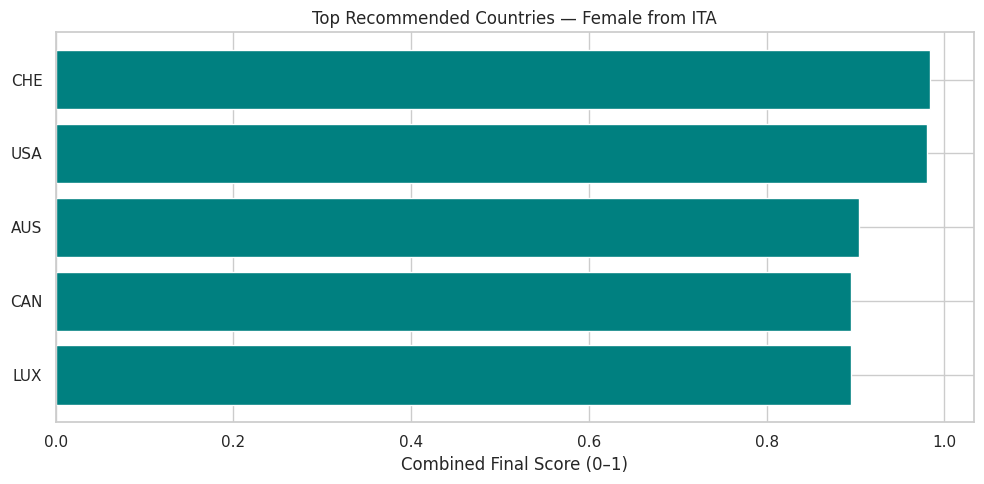

In [16]:
def _safe_minmax(series_or_df):
    arr = series_or_df.values if hasattr(series_or_df, "values") else np.asarray(series_or_df)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if np.nanmax(arr) - np.nanmin(arr) > 0:
        return MinMaxScaler().fit_transform(arr).ravel()
    else:
        # if constant -> all ones (keeps the channel active but neutral)
        return np.ones(arr.shape[0])

def recommend_countries(
    df,
    user_input,
    top_n=5,
    w_score=0.4,          # weight: normalized structural score (push+pull)
    w_sim=0.4,            # weight: cosine similarity
    w_flow=0.2,           # weight: migrant flows
    flow_log=True         # apply log1p to flows before min-max
):

    origin_country = user_input["origin_country"]
    sex = user_input["sex"]
    improve = user_input.get("indices_to_improve", {})  # push
    desire  = user_input.get("desired_indices", {})     # pull

    # ---- 1) Origin/Dest profiles ----
    origin_cols = [f"origin_{ind}" for ind in available_indices]
    dest_cols   = [f"dest_{ind}"   for ind in available_indices]

    origin_means = (
        df[df["country_of_birth"] == origin_country][origin_cols]
        .mean()
    )  # Series

    dest_means = (
        df.groupby("country_of_destination")[dest_cols]
        .mean()
        .copy()
    )  # DataFrame indexed by country_of_destination

    # ---- 2) Flows: origin -> destination, filtered by selected sex ----
    flows = (
        df[(df["sex"] == sex) & (df["country_of_birth"] == origin_country)]
        .groupby("country_of_destination")["number"]
        .sum()
    )
    # align to destinations in dest_means
    flows = flows.reindex(dest_means.index).fillna(0.0)
    if flow_log:
        flows = np.log1p(flows)  # stabilize heavy tails

    # ---- 3) Build user-specific table (one row per destination) ----
    df_user = dest_means.reset_index()  # has 'country_of_destination' + dest_* columns
    # add the origin_* baseline (same for all rows)
    for ind in available_indices:
        df_user[f"origin_{ind}"] = origin_means[f"origin_{ind}"]
    # add flows
    df_user["number"] = flows.values

    # ---- 4) Raw score (push + pull) and reasons ----
    def calculate_score(r):
        score = 0.0
        reasons = []

        # push: improvement vs origin
        for ind, weight in improve.items():
            delta = r[f"dest_{ind}"] - r[f"origin_{ind}"]
            score += delta * weight
            if delta >= 0.01:
                reasons.append(f"{ind} ↑ (+{delta:.2f})")

        # pull: absolute desirability
        sim_delta_added = set()  # avoid duplicate reason lines per indicator
        for ind, weight in desire.items():
            val = r[f"dest_{ind}"]
            delta = r[f"dest_{ind}"] - r[f"origin_{ind}"]
            score += val * weight
            if delta >= 0.01 and ind not in sim_delta_added:
                reasons.append(f"{ind} ↑ (+{delta:.2f})")
                sim_delta_added.add(ind)

        return pd.Series({"score": score, "reasons": reasons})

    df_user[["score", "reasons"]] = df_user.apply(calculate_score, axis=1)

    # ---- 5) Normalize channels ----
    df_user["score_norm"]   = _safe_minmax(df_user["score"])
    # cosine similarity
    if desire:
        sim_keys = list(desire.keys())
        profile = np.array([desire[k] for k in sim_keys]).reshape(1, -1)
        sim_indices = [f"dest_{k}" for k in sim_keys]
        destination_matrix = df_user[sim_indices].values
        similarity = cosine_similarity(profile, destination_matrix)[0]
    else:
        similarity = np.zeros(len(df_user))
    # similarity is already in [0,1] in this setting
    df_user["similarity"]   = similarity
    df_user["number_norm"]  = _safe_minmax(df_user["number"])

    # ---- 6) Final score (weighted sum; stays in [0,1]) ----
    df_user["final_score"] = (
        w_score * df_user["score_norm"] +
        w_sim   * df_user["similarity"] +
        w_flow  * df_user["number_norm"]
    )

    # ---- 7) Aggregate (robust if future multiple rows per destination) ----
    def summarize_reasons(series):
        flat = [item for sub in series.tolist() for item in sub]
        return sorted(set(flat))

    ranking = (
        df_user.groupby("country_of_destination")
        .agg({"final_score": "mean", "reasons": summarize_reasons})
        .sort_values("final_score", ascending=False)
        .reset_index()
        .head(top_n)
    )
    return ranking


# ---------------------------
# Execution and display
# ---------------------------
if "user_input" in globals():
    result = recommend_countries(
        df_final,
        user_input,
        top_n=5,
        w_score=0.4,
        w_sim=0.4,
        w_flow=0.2,
        flow_log=True
    )

    # Map country code -> full country name (destination)
    code_to_name = (
        df_final.drop_duplicates(subset="country_of_destination")
                .set_index("country_of_destination")["Country_dest"]
                .to_dict()
    )

    print(f" Top recommended countries for {user_input['sex']} migrants from {user_input['origin_country']}:\n")
    # Show full names in output
    for idx, row in result.iterrows():
        code = row["country_of_destination"]
        full_name = code_to_name.get(code, code)
        print(f"{idx + 1}. {code} — {full_name} : {row['final_score']:.4f}")
        for reason in row["reasons"]:
            print(" •", reason)
        print()

    # Bar chart
    result_plot = result.copy()
    result_plot["country_name"] = result_plot["country_of_destination"].map(code_to_name).fillna(result_plot["country_of_destination"])

    plt.figure(figsize=(10, 5))
    plt.barh(result_plot["country_of_destination"], result_plot["final_score"], color="teal")
    plt.xlabel("Combined Final Score (0–1)")
    plt.title(f"Top Recommended Countries — {user_input['sex']} from {user_input['origin_country']}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print(" Please generate 'user_input' using the interface before running recommendations.")


## Conclusion

This project provides an interactive and data-driven framework for analyzing international migration decisions based on both individual preferences and country-level indicators.

By combining demographic filters, well-being metrics, political freedom ratings, and user-defined priorities, we can:

- Explore global migration patterns and trends.
- Compare countries through visual and statistical tools.
- Group countries using clustering and dominance analysis.
- Recommend optimal destinations tailored to specific user profiles.

This approach demonstrates how personal choices and structural country conditions can be integrated to better understand migration dynamics in a complex, multidimensional world.

**Prefer a guided, no-code experience?**  
Try the interactive app version here: [https://braindrain-4zkeytvdhytywh6uhknkap.streamlit.app/](https://braindrain-4zkeytvdhytywh6uhknkap.streamlit.app/)

